In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import os
import numpy as np
from torch.optim import Adam
from torch.utils.data import DataLoader

from dataset import FlowDataset

In [2]:
class FlowLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(FlowLSTM, self).__init__()
        # build your model here
        # your input should be of dim (batch_size, seq_len, input_size)
        # your output should be of dim (batch_size, seq_len, input_size) as well
        # since you are predicting velocity of next step given previous one
        
        # feel free to add functions in the class if needed
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        
        if self.num_layers > 1:
            self.dropout = dropout
        else:
            self.dropout = 0.0
        
        # define the LSTM layer
        self.lstm = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            num_layers = self.num_layers,
            batch_first=True,
            dropout=self.dropout
        )
        
        # define the output layer
        self.dense = nn.Linear(self.hidden_size,self.input_size)
        
    # initialize hidden state as
    def initial_hidden_state(self,batch):
        return Variable(torch.zeros(self.num_layers,batch,self.hidden_size))


    # forward pass through LSTM layer
    def forward(self, x):
        '''
        input: x of dim (batch_size, 19, 17)
        '''
        # define your feedforward pass
        batch = x.shape[0]
        h_0 = self.initial_hidden_state(batch)
        h_1 = self.initial_hidden_state(batch)
        out, _ = self.lstm(x, (h_0, h_1))
        out = self.dense(out)
        return out


    # forward pass through LSTM layer for testing
    def test(self, x):
        '''
        input: x of dim (batch_size, 17)
        '''
        # define your feedforward pass
        pred = torch.empty(x.shape[0], 19, x.shape[1])
        pred[:,0,:] = x       
        
        for i in range(1, pred.shape[1]):
            pred[:,i,:] = self.forward(pred[:,:i,:])[:,-1,:]

        return pred

In [3]:
# from lstm import FlowLSTM

def main():
    # check if cuda available
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

    # define dataset and dataloader
    train_dataset = FlowDataset(mode='train')
    test_dataset = FlowDataset(mode='test')
    train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
    test_loader = DataLoader(dataset=test_dataset, batch_size=16, shuffle=False, num_workers=4)

    # hyper-parameters
    num_epochs = 45
    lr = 0.0008
    input_size = 17 # do not change input size
    hidden_size = 128
    num_layers = 6
    dropout = 0.2

    model = FlowLSTM(
        input_size=input_size, 
        hidden_size=hidden_size, 
        num_layers=num_layers, 
        dropout=dropout
    ).to(device)

    # define your LSTM loss function here
    loss_func = nn.MSELoss()

    # define optimizer for lstm model
    optim = Adam(model.parameters(), lr=lr)
    loss_list = []
    for epoch in range(num_epochs):
        for n_batch, (in_batch, label) in enumerate(train_loader):
            in_batch, label = in_batch.to(device), label.to(device)
            
            # train LSTM
            out = model(in_batch)
            # calculate LSTM loss
            loss = loss_func(out, label)

            optim.zero_grad()
            loss.backward()
            optim.step()

            # print loss while training
            loss_list.append(loss.item())
            if (n_batch + 1) % 200 == 0:
                print("Epoch: [{}/{}], Batch: {}, Loss: {}".format(
                    epoch+1, num_epochs, n_batch+1, loss.item()))

    # test trained LSTM model
    l1_err, l2_err = 0, 0
    l1_loss = nn.L1Loss()
    l2_loss = nn.MSELoss()
    
    
    model.eval()
    with torch.no_grad():
        for n_batch, (in_batch, label) in enumerate(test_loader):
            in_batch, label = in_batch.to(device), label.to(device)
            pred = model.test(in_batch)
            l1_err += l1_loss(pred, label).item()
            l2_err += l2_loss(pred, label).item()

    print("Test L1 error:", l1_err)
    print("Test L2 error:", l2_err)

    # visualize the prediction comparing to the ground truth
    if device == 'cpu':
        pred = pred.detach().numpy()[0,:,:]
        label = label.detach().numpy()[0,:,:]
    else:
        pred = pred.detach().cpu().numpy()[0,:,:]
        label = label.detach().cpu().numpy()[0,:,:]

    r = []
    num_points = 17
    interval = 1./num_points
    x = int(num_points/2)
    for j in range(-x,x+1):
        r.append(interval*j)

    from matplotlib import pyplot as plt
    plt.figure()
    for i in range(1, len(pred)):
        c = (i/(num_points+1), 1-i/(num_points+1), 0.5)
        plt.plot(pred[i], r, label='t = %s' %(i), c=c)
    plt.xlabel('velocity [m/s]')
    plt.ylabel('r [m]')
    plt.legend(bbox_to_anchor=(1,1),fontsize='x-small')
    plt.show()

    plt.figure()
    for i in range(1, len(label)):
        c = (i/(num_points+1), 1-i/(num_points+1), 0.5)
        plt.plot(label[i], r, label='t = %s' %(i), c=c)
    plt.xlabel('velocity [m/s]')
    plt.ylabel('r [m]')
    plt.legend(bbox_to_anchor=(1,1),fontsize='x-small')
    plt.show()

    plt.plot(loss_list)
    plt.title("Loss vs iterations")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()

Epoch: [1/45], Batch: 200, Loss: 2.3255193809745833e-05
Epoch: [1/45], Batch: 400, Loss: 6.974390089453664e-06
Epoch: [1/45], Batch: 600, Loss: 4.437452389538521e-06
Epoch: [1/45], Batch: 800, Loss: 3.559965762178763e-06
Epoch: [1/45], Batch: 1000, Loss: 3.371770390003803e-06
Epoch: [1/45], Batch: 1200, Loss: 3.0058367883611936e-06
Epoch: [2/45], Batch: 200, Loss: 1.5161417650233489e-06
Epoch: [2/45], Batch: 400, Loss: 2.0050592866027728e-06
Epoch: [2/45], Batch: 600, Loss: 1.497989956078527e-06
Epoch: [2/45], Batch: 800, Loss: 1.392068497807486e-06
Epoch: [2/45], Batch: 1000, Loss: 1.2230227639520308e-06
Epoch: [2/45], Batch: 1200, Loss: 6.150688705020002e-07
Epoch: [3/45], Batch: 200, Loss: 1.0360344049331616e-06
Epoch: [3/45], Batch: 400, Loss: 8.67429491790972e-07
Epoch: [3/45], Batch: 600, Loss: 5.785137204838975e-07
Epoch: [3/45], Batch: 800, Loss: 6.280916409195925e-07
Epoch: [3/45], Batch: 1000, Loss: 6.038130209162773e-07
Epoch: [3/45], Batch: 1200, Loss: 4.367250028280978e-07

Epoch: [25/45], Batch: 600, Loss: 6.091658377727072e-08
Epoch: [25/45], Batch: 800, Loss: 7.442552174552475e-08
Epoch: [25/45], Batch: 1000, Loss: 1.3898231543407746e-07
Epoch: [25/45], Batch: 1200, Loss: 7.951707914344297e-08
Epoch: [26/45], Batch: 200, Loss: 1.0837398178864532e-07
Epoch: [26/45], Batch: 400, Loss: 1.2328959542173834e-07
Epoch: [26/45], Batch: 600, Loss: 1.0887515600188635e-07
Epoch: [26/45], Batch: 800, Loss: 2.178762343874041e-07
Epoch: [26/45], Batch: 1000, Loss: 2.213676992823821e-07
Epoch: [26/45], Batch: 1200, Loss: 6.143208253206467e-08
Epoch: [27/45], Batch: 200, Loss: 1.0260980332077452e-07
Epoch: [27/45], Batch: 400, Loss: 1.7373409377796634e-07
Epoch: [27/45], Batch: 600, Loss: 4.228017189689126e-07
Epoch: [27/45], Batch: 800, Loss: 7.109301236596366e-08
Epoch: [27/45], Batch: 1000, Loss: 1.9014181873444613e-07
Epoch: [27/45], Batch: 1200, Loss: 1.954554704752809e-07
Epoch: [28/45], Batch: 200, Loss: 2.9972412107781565e-07
Epoch: [28/45], Batch: 400, Loss: 

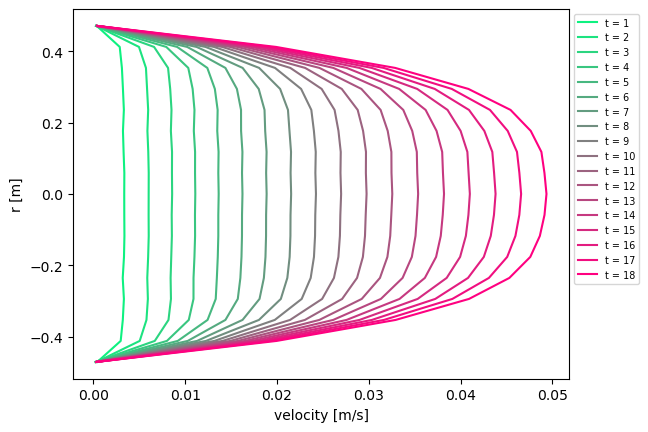

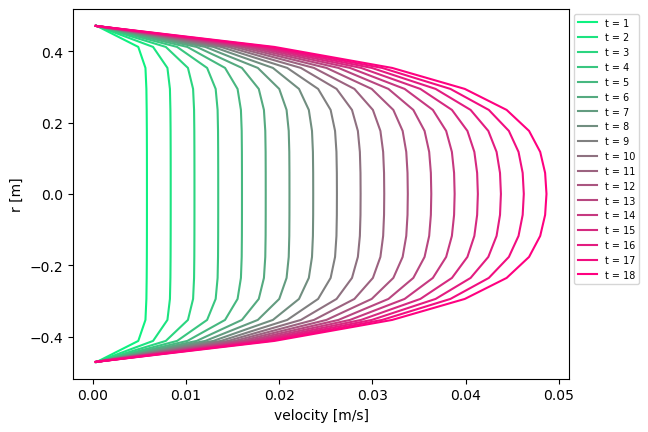

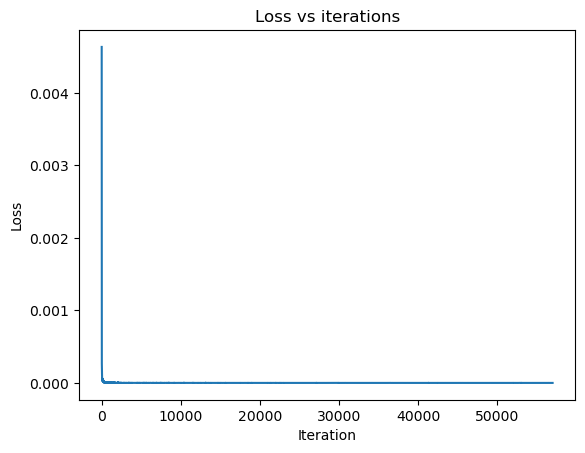

In [4]:
if __name__ == "__main__":
    main()